In [5]:
#Similar to the documentation, i'll be implementing different attention mechanisms
# Simple, Multi, 2Simplical Attention
## Standard libraries
import os
import numpy as np
import math
import json
from functools import partial

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.auto import tqdm

## To run JAX on TPU in Google Colab, uncomment the two lines below
# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

## JAX
import jax
import jax.numpy as jnp
from jax import random
# Seeding for random operations
main_rng = random.PRNGKey(42)

## Flax (NN in JAX)
from flax import linen as nn
from flax.training import train_state, checkpoints

## Optax (Optimizers in JAX)

import optax

## PyTorch
import torch
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR100

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "/Users/atreyasridharan/miniforge3/bin/JAX_learning/data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "/Users/atreyasridharan/miniforge3/bin/JAX_learning/tutorial6_jax"

print("Device:", jax.devices()[0])

Device: TFRT_CPU_0


/var/folders/d7/pbk8bck12h7bh19pktsg__3w0000gn/T/ipykernel_85237/2725606648.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


<Figure size 640x480 with 0 Axes>

In [6]:
#Don't really need this, just doing it to check model benchmarks

import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/JAX/tutorial6/"
# Files to download
pretrained_files = ["ReverseTask.ckpt", "SetAnomalyTask.ckpt"]

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [8]:
#Single attention

def scaled_dot_product(q,k,v, mask=None):
    d_k = q.shape[-1]
    attn_logits = jnp.matmul(q, jnp.swapaxes(k, -2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = jnp.where(mask == 0, -9e15, attn_logits)
    attention = nn.softmax(attn_logits, axis=-1)
    values = jnp.matmul(attention,v)
    return values, attention


In [9]:
seq_len, d_k = 3 , 2
main_rng ,rand1 = random.split(main_rng)
qkv = random.normal(rand1, (3, seq_len, d_k))
q, k, v = qkv[0], qkv[1], qkv[2]
values, attention = scaled_dot_product(q, k, v)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)

Q
 [[ 0.60576403  0.7990441 ]
 [-0.908927   -0.63525754]
 [-1.2226585  -0.83226097]]
K
 [[-0.47417238 -1.2504351 ]
 [-0.17678244 -0.04917514]
 [-0.41177532 -0.39363015]]
V
 [[ 1.3116323   0.21555556]
 [ 0.41164538 -0.28955024]
 [-0.96516913  0.4492738 ]]
Values
 [[0.12734914 0.06441191]
 [0.4115729  0.17320421]
 [0.46902645 0.1854193 ]]
Attention
 [[0.20383833 0.4564296  0.33973208]
 [0.46830934 0.2255167  0.30617398]
 [0.51187545 0.19520193 0.29292265]]


In [10]:
#Helper func for diff mask shapes
def expand_mask(mask):
    assert mask.ndim >= 2
    if mask.ndim == 3:
        mask = mask.unsqueeze(1)
    while mask.ndim < 4:
        mask = mask.unsqueeze(0)
    return mask

In [15]:
from typing import Any


class MultiheadAttention(nn.Module):
    embed_dim : int
    num_heads : int

    def setup(self):
        self.qkv_proj = nn.Dense(3*self.embed_dim,
                                 kernel_init=nn.initializers.xavier_uniform(),
                                 bias_init= nn.initializers.zeros)
        
        self.o_proj = nn.Dense(self.embed_dim,
                               kernel_init= nn.initializers.xavier_uniform(),
                               bias_init= nn.initializers.zeros)
        
    def __call__(self, x, mask=None):
        batch_size, seq_length, embed_dim = x.shape
        if mask is not None:
            mask = expand_mask(mask)
        qkv = self.qkv_proj(x)

        qkv = qkv.reshape(batch_size,seq_length, self.num_heads, -1)
        qkv = qkv.transpose(0,2,1,3)
        q,k,v = jnp.array_split(qkv, 3, axis=-1)

        #Determine value outputs
        values, attention = scaled_dot_product(q,k,v, mask=mask)
        values = values.transpose(0,2,1,3)
        values = values.reshape(batch_size, seq_length, embed_dim)
        o = self.o_proj(values)

        return o,attention

In [16]:
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 128))
# Create attention
mh_attn = MultiheadAttention(embed_dim=128, num_heads=4)
# Initialize parameters of attention with random key and inputs
main_rng, init_rng = random.split(main_rng)
params = mh_attn.init(init_rng, x)['params']
# Apply attention with parameters on the inputs
out, attn = mh_attn.apply({'params': params}, x)
print('Out', out.shape, 'Attention', attn.shape)

del mh_attn, params

Out (3, 16, 128) Attention (3, 4, 16, 16)


In [17]:
#Encoder
from typing import Any


class EncoderBlock(nn.Module):
    input_dim : int
    num_heads : int
    dim_feedforward : int
    dropout_prob : float

    def setup(self):
        self.self_attn = MultiheadAttention(embed_dim=self.input_dim, num_heads=self.num_heads)

        self.linear = [
            nn.Dense(self.dim_feedforward),
            nn.Dropout(self.dropout_prob),
            nn.relu,
            nn.Dense(self.input_dim)
        ]

        self.norm1 = nn.LayerNorm()
        self.norm2 = nn.LayerNorm()
        self.dropout = nn.Dropout(self.dropout_prob)

    def __call__(self, x, mask=None, train = True):
        attn_out, _ = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out, deterministic=not train)
        x = self.norm1(x)

        linear_out = x
        for l in self.linear:
            linear_out = l(linear_out) if not isinstance(l, nn.Dropout) else l(linear_out, deterministic= not train)
        x = x + self.dropout(linear_out, deterministic= not train)
        x = self.norm2(x)

        return x


        

In [19]:
class TransformerEncoder(nn.Module):
    num_layers : int
    input_dim : int
    num_heads : int
    dim_feedforward : int
    dropout_prob : float

    def setup(self):
        self.layers = [EncoderBlock(self.input_dim, self.num_heads, self.dim_feedforward, self.dropout_prob) for _ in range(self.num_layers)]

    def __call__(self, x, mask=None, train=True):
        for l in self.layers:
            x = l(x, mask=mask, train=train)
        return x

    def get_attention_maps(self, x, mask=None, train=True):
        # A function to return the attention maps within the model for a single application
        # Used for visualization purpose later
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask)
            attention_maps.append(attn_map)
            x = l(x, mask=mask, train=train)
        return attention_maps

In [40]:
#RoPE (Not in the tutorial)

class RotaryPositionalEmbedding(nn.Module):
    d_model : int
    max_seq_len : int

    def setup(self):
        # Create rotation matrix
        self.rotation_matrix = jnp.zeros((self.d_model, self.d_model), dtype=jnp.float32)
        for i in range(self.d_model):
            for j in range(self.d_model):
                self.rotation_matrix = self.rotation_matrix.at[i,j].set(jnp.cos(i * j * 0.01))
        
        # Create positional embeddings
        self.positional_embeddings = jnp.zeros((self.max_seq_len, self.d_model), dtype=jnp.float32)
        for i in range(self.max_seq_len):
            for j in range(self.d_model):
                self.positional_embeddings = self.positional_embeddings.at[i,j].set(jnp.cos(i * j * 0.01))
        
    def __call__(self, x, mask=None, train=True):
        x = x + self.positional_embeddings[:x.shape[0], :]  # Add positional embeddings
        x = jnp.matmul(x, self.rotation_matrix)  # Apply rotation
        return x
        




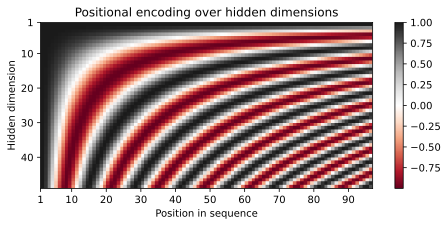

In [43]:
encod_block = RotaryPositionalEmbedding(d_model=48, max_seq_len=96).bind({})
# Obtain positional encodings as numpy array
pe = jax.device_get(encod_block.positional_embeddings.squeeze().T)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*10 for i in range(1,1+pe.shape[1]//10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])
plt.show()